In [1]:
import os
import numpy as np
import random
import torch
from moleculekit.molecule import Molecule
import matplotlib.pyplot as plt
import parmed
import nglview as ng
import MDAnalysis as md

import openmm.app as app
from openmm import Platform, LangevinMiddleIntegrator, XmlSerializer
from openmm.unit import picosecond, kelvin
from openmm import unit
import openmm

import mymd

In [2]:
seed = 142
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
data_path = 'data/aspirin/'
csv_path = 'data/aspirin/rslt_mymd/'
dcd_path = 'data/aspirin/rslt_mymd/'

pdb_file = os.path.join(data_path, 'aspirin.pdb')
psf_file = os.path.join(data_path, 'aspirin.psf')
prmtop_file = os.path.join(data_path, 'aspirin.prmtop')

cutoff = 5
T = 300
dt_fs = 2
dcd_interval = 100
csv_interval = 50
steps = 50000
min_energy_max_iter = 100
box_size = 100
device = 'cpu'
precision = torch.float
use_centered = True

In [4]:
mol = mymd.get_molecule(prmtop_file=prmtop_file, pdb_file=pdb_file)

try:
    ff = mymd.PrmtopMolForceField(mol, prmtop_file, allow_unequal_duplicates=False)
except:
    print('False causes error, use True.')
    ff = mymd.PrmtopMolForceField(mol, prmtop_file, allow_unequal_duplicates=True)

system = mymd.System(mol, ff, cutoff=cutoff)
system.set_periodic_box_manual(np.array([box_size, box_size, box_size]).reshape(3, 1))

integrator = mymd.VelocityVerletIntegrator(dt_fs)

2023-05-15 22:08:43,411 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [5]:
simulation = mymd.Simulation(mol, system, integrator, device, precision, use_centered=use_centered)
simulation.set_positions(mol.coords)
simulation.set_velocities_to_temperature(T=T)
simulation.update_potentials_and_forces()

csv_reporter = mymd.CSVReporter(csv_path, csv_interval)
simulation.add_reporter(csv_reporter)

Remove the original csv file.


In [6]:
print(simulation.potentials)
print(simulation.potentials_sum)

simulation.minimize_energy(min_energy_max_iter)

print(simulation.potentials)
print(simulation.potentials_sum)

{'bonds': 3.0544779300689697, 'angles': 1.7067383527755737, 'dihedrals': 5.644763469696045, 'impropers': 0.026793889701366425, 'lj': 18.31438446044922, 'electrostatics': -73.98635864257812, 'external': 0.0}
-45.23920053988695
num_fun_eval	E_pot    	norm_F_max	rms      	max_abs_f_1d
     0      	-45.239201	73.376954	18.392003	72.161987
     1      	784.985586	1356.483672	260.006125	1090.798462
     2      	-50.397495	29.080688	8.024108	28.039185
     3      	-51.889034	20.120077	5.831538	16.933207
     4      	-54.087225	19.349260	5.487012	17.499695
     5      	-60.725293	26.994301	7.322988	24.831690
     6      	-69.513363	28.525015	7.302995	25.441042
     7      	-70.160228	7.061892	2.082237	6.172187
     8      	-70.288255	6.974341	1.715494	5.877006
     9      	-70.567340	6.179103	2.182816	5.097136
     10     	-70.810570	11.489814	3.143966	10.953133
     11     	-71.024032	5.600674	1.804522	5.261780
     12     	-71.133911	4.501040	1.219405	3.476378
     13     	-71.206791	3.62147

In [7]:
simulation.step(steps, dcd_path, dcd_interval)

Remove the original dcd file.


100%|██████████| 50000/50000 [02:16<00:00, 366.76it/s]


In [8]:
u = md.Universe(psf_file, os.path.join(dcd_path, 'traj.dcd'))
ng.show_mdanalysis(u, gui=True)

2023-05-15 22:11:00,319 - MDAnalysis.topology.PSF - WARNING - Guessing that this is actually a NAMD-type PSF file... continuing with fingers crossed!


NGLWidget(max_frame=500)

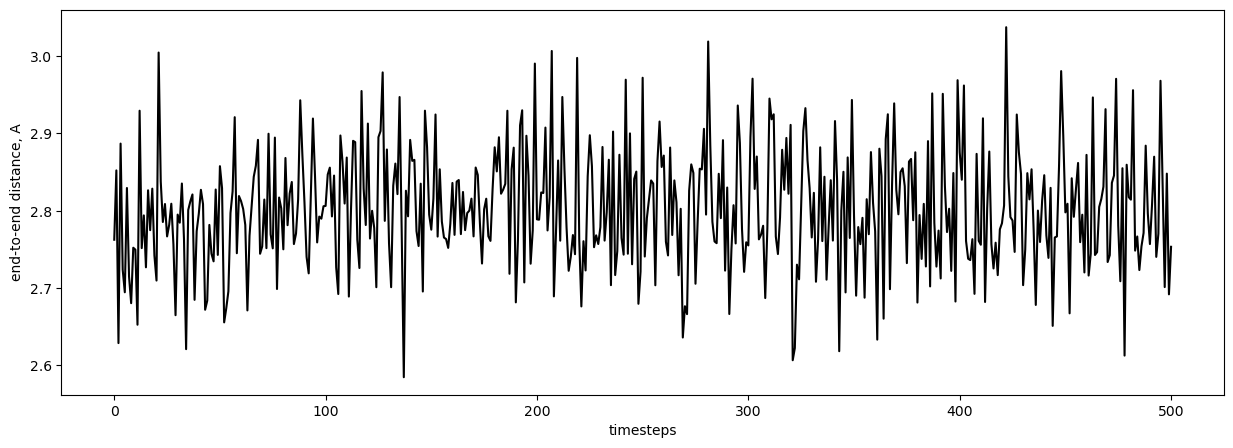

In [9]:
N_terminus = u.select_atoms('resid 1 and name O1')
C_terminus = u.select_atoms('resid 1 and name O2')

# go through the whole trajectory and compute distance between them for every frame
dist = []
for frame in u.trajectory:
    dist.append(np.linalg.norm(N_terminus.positions - C_terminus.positions))

# the result is in the dist array
dist = np.array(dist)
plt.figure(figsize=(15,5))

plt.plot(dist, '-k' )
plt.xlabel('timesteps')
plt.ylabel('end-to-end distance, A')

plt.show()